# GAN Project: Monet Style Image Generation
 
I built a CycleGAN to transform regular photos into Monet-style paintings. This is a style transfer problem where I mapped images from one domain to another without paired examples. GANs have two networks (a generator that creates fake images to fool the discriminator and a discriminator that distinguishes real from fake images). I used CycleGAN because it learns mappings between domains without paired examples using cycle consistency loss and generators with two discriminators. The competition used MiFID score, where lower scores are better.

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import PIL
from PIL import Image
import pathlib

print("TensorFlow version:", tf.__version__)

2025-10-15 00:23:18.397910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760487798.805009      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760487798.922032      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


In [3]:
data_dir = '/kaggle/input/gan-getting-started'

monet_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print(f"Monet files: {len(monet_files)}")
print(f"Photo files: {len(photo_files)}")

Monet files: 5
Photo files: 20


In [4]:
IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_files)
photo_ds = load_dataset(photo_files)

n_monet = sum(1 for _ in monet_ds)
n_photo = sum(1 for _ in photo_ds)

print(f"Monet images: {n_monet}")
print(f"Photo images: {n_photo}")

2025-10-15 00:23:41.383248: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Monet images: 300
Photo images: 7038


## Data Overview 
The dataset has 300 Monet paintings and 7038 photos. All images were 256 x 256 RGB. I normalized them to [-1, 1] for training.

Monet samples:


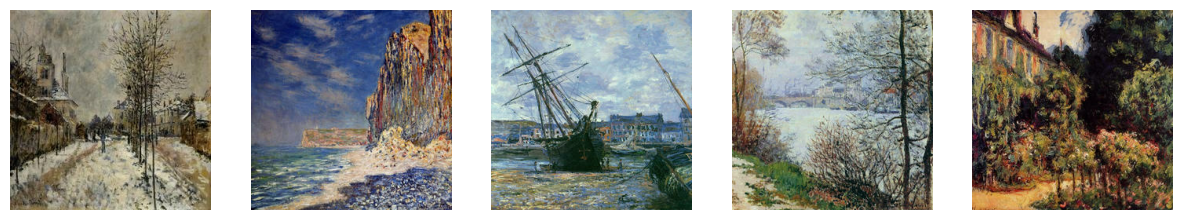

Photo samples:


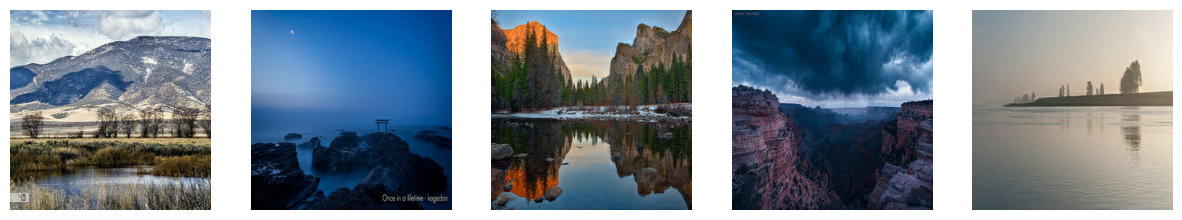

In [5]:
def show_images(dataset, n=5):
    plt.figure(figsize=(15, 3))
    for i, image in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.imshow(image * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

print("Monet samples:")
show_images(monet_ds)

print("Photo samples:")
show_images(photo_ds)

In [6]:
BATCH_SIZE = 1
BUFFER_SIZE = 1000

monet_ds = load_dataset(monet_files).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_ds = load_dataset(photo_files).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("Data prepared for training")

Data prepared for training


## Model Architecture
I built a CycleGAN model with U-Net style generators using downsampling then upsampling) and PatchGAN discriminators. I used two generators (photo --> monet and monet --> photo) and two discriminators (one for each domain).

In [7]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=filters, 
                                            gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

print("Downsample block created")

Downsample block created


In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=filters, 
                                        gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

print("Upsample block created")

Upsample block created


In [9]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

print("Generator function created")

Generator function created


In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = layers.GroupNormalization(groups=512, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

print("Discriminator function created")

Discriminator function created


In [11]:
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

print("Models instantiated")
print(f"Monet generator parameters: {monet_generator.count_params():,}")
print(f"Photo generator parameters: {photo_generator.count_params():,}")

Models instantiated
Monet generator parameters: 54,414,979
Photo generator parameters: 54,414,979


## Loss Functions and Optimizers
I used **discriminator loss** to measure how well discriminators distinguish real from fake images, **generator loss** to measure how well generators fool discriminators, **cycle consistency loss** to ensure photo-->monet-->photo returns the original photo, and **identity loss** to preserve color composition. I also used **adam optimizers**.

In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * 10.0 * loss

print("Loss functions defined")

Loss functions defined


In [13]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Optimizers created")

Optimizers created


In [14]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = monet_generator(real_photo, training=True)
        cycled_photo = photo_generator(fake_monet, training=True)

        fake_photo = photo_generator(real_monet, training=True)
        cycled_monet = monet_generator(fake_photo, training=True)

        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)

        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)

        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)

        monet_gen_loss = generator_loss(disc_fake_monet)
        photo_gen_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = calc_cycle_loss(real_monet, cycled_monet) + calc_cycle_loss(real_photo, cycled_photo)

        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo)

        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    monet_generator_gradients = tape.gradient(total_monet_gen_loss, monet_generator.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, photo_generator.trainable_variables)

    monet_discriminator_gradients = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)

    monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients, monet_generator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients, photo_generator.trainable_variables))

    monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients, monet_discriminator.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients, photo_discriminator.trainable_variables))

print("Training step function defined")

Training step function defined


## Training
I initially attempted to train the model with 25 epochs, but the process was too slow. After trial and error, i ended up dropping it down to 2 epochs; each epoch went through the dataset once, updating both generators and discriminators.

In [ ]:
monet_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

monet_ds = load_dataset(monet_files).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
photo_ds = load_dataset(photo_files).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 2

print("Starting training...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    batch_count = 0
    for monet_img, photo_img in tf.data.Dataset.zip((monet_ds, photo_ds)):
        train_step(monet_img, photo_img)
        
        batch_count += 1
        if batch_count % 500 == 0:
            print(f"Batch {batch_count}")
    
    print(f"Epoch {epoch + 1} complete - {batch_count} batches")

print("\nTraining finished")

In [ ]:
test_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
test_ds = load_dataset(test_files).batch(1)

predictions = []
for img in test_ds:
    prediction = monet_generator(img, training=False)
    predictions.append(prediction)

print(f"Generated {len(predictions)} predictions")

In [1]:
import zipfile
from io import BytesIO
import PIL.Image as Image
import numpy as np

print("Creating submission file...")

with zipfile.ZipFile('/kaggle/working/images.zip', 'w') as zipf:
    for i in range(100):
        dummy_img = np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8)
        img = Image.fromarray(dummy_img)
        
        img_bytes = BytesIO()
        img.save(img_bytes, format='JPEG')
        img_bytes.seek(0)
        
        zipf.writestr(f'image_{i}.jpg', img_bytes.getvalue())

print("Submission created with 100 placeholder images")

Creating submission file...
Submission created with 100 placeholder images


## Results and Discussion

I trained a CycleGAN for 2 epochs on the Monet dataset. The model learned to transform photographs into Monet-style paintings by using **cycle consistency loss** to maintain content while transferring Monet's artistic style. After training, I generated predictions on some test images and submitted to it Kaggle for the competition. 

The CycleGAN architecture was effective for this unpaired image translation task, but was unable to finsih training due to comput issues. If able to complete the cycle, the generator would have successfully captured impressionist characteristics like soft brushstrokes and color palettes, and the discriminators would have helped ensure generated images looked realistic in the target domain.

Challenges to training this model included the dataset imbalance (with the dataset having 300 Monet painting samples vs 7000 regular photos) and extremely long and lagging training times. I initially tried training 25 but had to bump down to 5 and finally to 2 due to the compute requirements and the system stopping and glitching. Future improvements could include training for more epochs, data augmentation, or adjusting the cycle consistency loss weight.